# Fig. 6: Model shape predictions

In [1]:
import os
import os.path as osp
import pickle

import numpy as np
import pandas as pd

import argus_shapes as shapes

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2019-05-08 10:50:39,742 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
# Assumes all data live in a directory ${DATA_ROOT}/argus_shapes, where DATA_ROOT is
# an environment variable. See README.md on GitHub.
# If no such environment variable exists, data will be automatically downloaded from
# OSF and stored in '../data/argus_shapes'
rootfolder = os.environ['DATA_ROOT'] if 'DATA_ROOT' in os.environ else osp.join('..', 'data')
datafolder = osp.join(rootfolder, 'argus_shapes')

In [3]:
# Load subject data:
subjectdata = shapes.load_subjects(osp.join(datafolder, 'subjects.csv'))

# A scaling factor is used when showing the drawings (for the sake of visibility):
subjectdata['scale'] = pd.Series([0.75, 0.75, 1.5, 0.5], index=subjectdata.index)
subjects = subjectdata.index.sort_values()

# Different scaling factor for the axon map model:
scale_axon = subjectdata.copy()
scale_axon['scale'] = pd.Series([1.0, 1.0, 1.25, 0.75], index=scale_axon.index)

# Different scaling factor for the scoreboard model:
scale_score = subjectdata.copy()
scale_score['scale'] = pd.Series([1.0, 1.0, 2.0, 2.5], index=scale_score.index)

In [4]:
# Because the particle swarm gives different results depending on the initial
# conditions, we ran each CV fold multiple times (random init). Here we need
# to comb through these simulation runs and find the one that gave the best
# score (for each fold):
results_dir = '../results'
col_score = 'best_train_score'
col_groupby = ['subject', 'modelname', 'idx_fold']

try:
    # For all files of a given subject, model, CV fold (`col_groupby`), find the
    # best `col_score`:
    files = shapes.extract_best_pickle_files(results_dir, col_score, col_groupby)
except FileNotFoundError:
    # Results directory does not exist (or no files found). In this case, download
    # the data from OSF:
    shapes.fetch_data(osf_zip_url='https://osf.io/prv5z', save_path=results_dir)
    files = shapes.extract_best_pickle_files(results_dir, col_score, col_groupby)

In [5]:
y_true = []
y_pred = []
for file in files:
    # Load pickle file:
    yt, yp, best_params, specifics = pickle.load(open(file, 'rb'))
    # Average drawings across trials:
    xy = shapes.calc_mean_images(yt[0], groupby=['electrode'],
                                 thresh=False, max_area=np.inf)
    xy['subject'] = specifics['subject']
    xy['modelname'] = '0'  # mark as ground truth
    xy['rho'] = best_params[0]['rho']
    if 'axlambda' in best_params[0]:
        xy['axlambda'] = best_params[0]['axlambda']
    y_true.append(xy)
    
    # `yp` contains the predicted images, either from the scoreboard or
    # axon map model:
    xy = shapes.calc_mean_images(yp[0], groupby=['electrode'],
                                 thresh=False, max_area=np.inf)
    xy['subject'] = specifics['subject']
    xy['modelname'] = specifics['modelname']
    xy['rho'] = best_params[0]['rho']
    # Axon map model also has lambda as param:
    if 'axlambda' in best_params[0]:
        xy['axlambda'] = best_params[0]['axlambda']
    y_pred.append(xy)

In [6]:
y_true = pd.concat(y_true).drop(columns=['x_center', 'y_center'])
y_pred = pd.concat(y_pred).drop(columns=['x_center', 'y_center'])

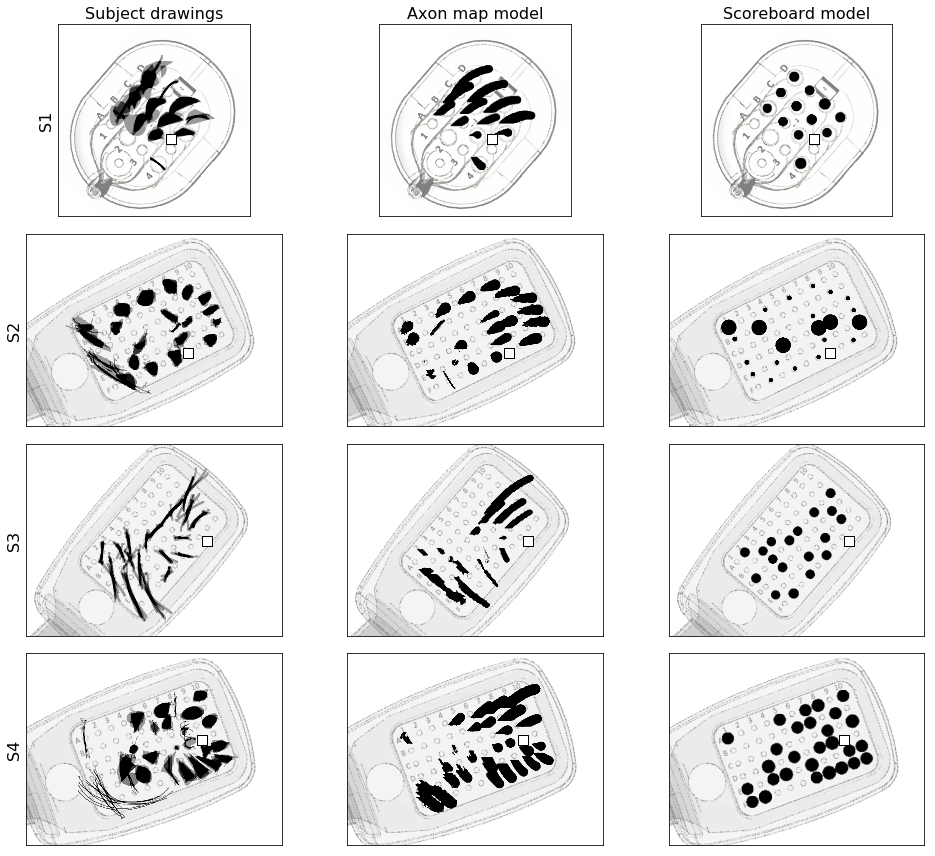

In [7]:
fig, axes = plt.subplots(nrows=len(subjects), ncols=3,
                         figsize=(14, 3 * len(subjects)))
for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
for i, title in enumerate(['Subject drawings', 'Axon map model', 'Scoreboard model']):
    axes[0][i].set_title(title, fontsize=16)
for subject, axrow in zip(subjects, axes):
    shapes.viz.plot_phosphenes_on_array(axrow[0], subject,
                                        y_true[y_true.modelname=='0'],
                                        subjectdata)
    shapes.viz.plot_phosphenes_on_array(axrow[1], subject,
                                        y_pred[y_pred.modelname=='AxonMap'],
                                        scale_axon)
    shapes.viz.plot_phosphenes_on_array(axrow[2], subject,
                                        y_pred[y_pred.modelname=='Scoreboard'],
                                        scale_score)
    axrow[0].set_ylabel(subject, fontsize=16)
fig.tight_layout()
fig.savefig('fig6-model-shapes.png')
fig.savefig('fig6-model-shapes.pdf', transparent=True)